# Paillier Crypto

## Load Public Key

In [1]:
import torch
import os

if not os.path.isfile('/tmp/public.key'):
    raise FileNotFoundError("Public Key is not found. Generate it using the `paillier_crypto_server` script.")
else:
    public_key = torch.load('/tmp/public.key')
    print("Load public key from /tmp/public.key")
    print(public_key)

Load public key from /tmp/public.key
<OpenFed> PublicKey
n_lwe: 3000, bits: 32, bits_safe: 24, l: 64, bound: 8, p: 4294967297, q: 4294967296



/Users/densechen/miniconda3/envs/openfed/lib/python3.7/site-packages/openfed-0.0.0-py3.7.egg/openfed/third_party/mmcv/__init__.py:13: UserWarning: `openfed.third_party.mmcv` module requires `mmcv` package, but not found. You can install it from https://github.com/open-mmlab/mmcv.


## Download Dataset

In [2]:
from openfed.data import IIDPartitioner, PartitionerDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

dataset = PartitionerDataset(
    MNIST(r'/tmp/', True, ToTensor(), download=True), total_parts=10, partitioner=IIDPartitioner())

## Dataloader

In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=False)

## Network

In [4]:
import torch.nn as nn

network = nn.Linear(784, 10)
loss_fn = nn.CrossEntropyLoss()

## Build Optimizer

In [5]:
import torch

from openfed.optim import build_fed_optim

optim = torch.optim.SGD(network.parameters(), lr=0.1)
fed_optim = build_fed_optim(optim)

print(fed_optim)

<OpenFed> Gluer
Gluer_SGD_Penalizer



## World

In [6]:
from openfed.core import World, follower

world = World(role=follower, dal=False, mtt=5)

print(world)

<OpenFed> World
+-----------------+-------+-------+-----+------+
|       role      | alive |  dal  | mtt | pipe |
+-----------------+-------+-------+-----+------+
| openfed_foll... |  True | False |  5  |  0   |
+-----------------+-------+-------+-----+------+



## API

In [7]:
from openfed import API

openfed_api = API(
    world=world,
    state_dict=network.state_dict(keep_vars=True),
    fed_optim=fed_optim)

print(openfed_api)

<OpenFed> OpenFedAPI
ROLE: openfed_follower



## Paillier Crypto Hook

In [8]:
from openfed.hooks import PaillierCrypto

with openfed_api:
    paillier_crypto = PaillierCrypto(public_key)
    print(paillier_crypto)

## Address

In [9]:
from openfed.common import default_tcp_address

address = default_tcp_address

print(address)

Address(backend='gloo', init_method='tcp://localhost:1994', world_size=2, rank=-1, store=None, group_name='OpenFed')


## Connection

In [10]:
openfed_api.build_connection(address=address)

print(openfed_api.maintainer)

<OpenFed> Maintainer
+---------+----------+---------+
| Pending | Finished | Discard |
+---------+----------+---------+
|    0    |    1     |    0    |
+---------+----------+---------+



## Train Loop

In [11]:
import random
import time

version = 0
outter_losses = []
for outter in range(50):
    success = True
    inner_losses = []
    for inner in range(2):
        openfed_api.update_version(version)
        if not openfed_api.transfer(to=False):
            print("Download failed.")
            success = False
            break
            
        part_id = random.randint(0, 9)
        dataset.set_part_id(part_id)
        
        network.train()
        losses = []
        tic = time.time()
        for data in dataloader:
            x, y = data
            output = network(x.view(-1, 784))
            loss = loss_fn(output, y)

            fed_optim.zero_grad()
            loss.backward()
            fed_optim.step()
            losses.append(loss.item())
        toc = time.time()
        loss = sum(losses)/len(losses)
        duration = toc-tic

        fed_optim.round()
        openfed_api.update_version(version+1)
        
        if not openfed_api.transfer(to=True):
            print("Upload failed.")
            success = False
            break
        else:
            fed_optim.clear_buffer()

        inner_losses.append(loss)
    outter_losses.append(sum(inner_losses) / len(inner_losses))
    if not success:
        break
    version += 1
print("Finished.")

Finished.


## Loss

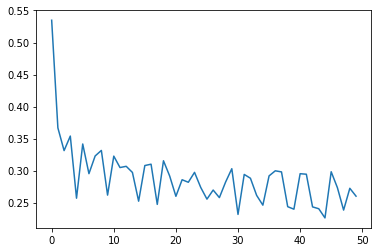

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
plt.plot(outter_losses)
plt.show()